# Phase 1 - Ingestion and Cleaning

In the Phase 2 of the Case Study, we will carry out the following steps:
  - Ingest raw downloaded data
  - Output a combined dataset ready for analysis and modeling

In [2]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# A helper function that you'll be using while reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

## Parameters

In [5]:
# Define the directories that contain the files downloaded
dir_cs = '/content/drive/MyDrive/MLPS Project/case_study_data/2003_download' # path to the directory where all the *.csv.zip files are located

# Define the output path for the pickle
pickle_file = "/content/drive/MyDrive/MLPS Project" + "clean_data.pickle" # path to save cleaned data

In [6]:
# Identify the columns we'll be keeping from the dataset
cols_to_pick = ['id', 'loan_amnt',
'funded_amnt', 'term', 'int_rate', 'grade', 'emp_length', 'home_ownership',
'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti',
'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec', 'fico_range_high',
'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt', 'recoveries', 'last_pymnt_d'] # list of features to use for this study as indicated in the handout

# Identify the type of each of these column based on your CS-Phase 1 response
float_cols = ['loan_amnt', 'funded_amnt', 'annual_inc', 'dti', 'open_acc', 'fico_range_high', 'fico_range_low', 'revol_bal', 'total_pymnt', 'recoveries','delinq_2yrs', 'pub_rec']
cat_cols = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose'] # categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [7]:
# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
#
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features

discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

## Ingestion
Ingest the data files from both sets, perform consistency checks, and prepare one single file for each set

In [8]:
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.

    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we
    assume the files are zipped (pd.read_csv can read zipped files)
    and we assume the first line in each file needs to be skipped.

    Note that each file will be read *without* formatting
    '''

    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory += "/"

    all_files = os.listdir(directory) # get list of all files from the directory
    output = {}

    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(directory + i, dtype='str', skiprows=1) # read each with dtype='str' and skip_rows =1

        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = ~output[i]['id'].astype(str).str.isdigit() # mask rows that have non-integer IDs. Use is_integer method
        if invalid_rows.sum() > 0:
            print("Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = output[i][~invalid_rows] # remove invalid rows

    return output # return dictionary of dataframe

In [9]:
# Ingest the set of files we downloaded using the defined method "ingest_files"
files_cs = ingest_files(dir_cs) # dictioary of (filename, dataframe) as (key, value)

Directory /content/drive/MyDrive/MLPS Project/case_study_data/2003_download/ has 20 files:
    Reading file LoanStats_securev1_2019Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3a_securev1.csv.zip
Found 3 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3d_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2018Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q1.csv.zip
Found 2 invalid rows which were removed
    Readi

### Combine the files

In [10]:
data_cs = pd.concat(files_cs.values(), ignore_index=True) # combine "files_cs" into a pandas dataframe
data_cs.reset_index(drop=True, inplace=True)              # resent index with drop = True

## Prepare Final Dataset

In [11]:
# Keep only the columns of interest from 'data_cs'
final_data = data_cs[cols_to_pick]

In [12]:
print("Starting with " + str(len(final_data)) + " rows")

Starting with 2777776 rows


In [13]:
del data_cs
import gc
gc.collect()

0

In [14]:
final_data.head()

,id,loan_amnt,funded_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,...,earliest_cr_line,open_acc,pub_rec,fico_range_high,fico_range_low,revol_bal,revol_util,total_pymnt,recoveries,last_pymnt_d
0,164027473,20000,20000,36 months,12.40%,B,< 1 year,RENT,13000,Verified,...,Dec-2010,6,1,669,665,12325,59.3%,647.45,0.0,Feb-2020
1,163984413,16500,16500,60 months,10.33%,B,NaN,MORTGAGE,26000,Source Verified,...,Feb-2005,8,0,779,775,15000,30.9%,339.07,0.0,Feb-2020
2,164193225,7500,7500,36 months,12.40%,B,7 years,RENT,159000,Verified,...,Sep-1997,18,0,714,710,16195,30.7%,842.8,0.0,Feb-2020
3,162948736,19000,19000,36 months,6.46%,A,10+ years,MORTGAGE,83000,Verified,...,Jun-1997,7,0,789,785,11068,28.8%,1153.75,0.0,Feb-2020
4,164161686,10000,10000,36 months,20.55%,D,10+ years,MORTGAGE,110000,Source Verified,...,Feb-2006,14,0,769,765,4941,18.4%,357.33,0.0,Feb-2020


### Typecast the columns

In [15]:
# Remember that we read the data as string (without any formatting).
# Now we would typecast the columns based on feature types which you found out in CS Phase 1

for i in float_cols:
    final_data[i] = final_data[i].astype(float) # typecast float columns

In [16]:
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

for i in perc_cols:
    final_data[i] = final_data[i].apply(clean_perc) # apply clean_perc to percentage columns

In [17]:
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

for i in date_cols:
    final_data[i] = final_data[i].apply(clean_date)# typecast date cloumns to datatime using clean_date

In [18]:
for i in cat_cols:
    final_data[i] = final_data[i].apply(lambda x: None if pd.isnull(x) or x == '' else x) # for categorical features if the value is null/empty set it to None

## Calculate returns for each loan

In [19]:
gc.collect()

0

In [20]:
# Define the names of the four returns we'll be calculating as described in Q.6
# ret_PESS: Pessimistic return
# ret_OPT: Optimistic return
# ret_INTa, ret_INTb: Method3 at two differnt values of "i"
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb"]

In [21]:
# Remove all rows for loans that were paid back on the days they were issued
final_data['issue_d'] = pd.to_datetime(final_data['issue_d'])
final_data['last_pymnt_d'] = pd.to_datetime(final_data['last_pymnt_d'])
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')
n_rows = len(final_data)

final_data = final_data[final_data['loan_length'] != 0] # select rows where loan_length is not 0.

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 12361 rows


### M1-Pessimistic Method

In [22]:
# Calculate the return using a simple annualized profit margin
# Pessimistic definition (Handout 6a.) (M1)

final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int) # length of loan in months

final_data['ret_PESS'] = (final_data['total_pymnt'] - final_data['funded_amnt']) / final_data['funded_amnt'] * (12 / final_data['term_num'])

### M2-Optimistic Method

In [23]:
# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use M1-pessimistic to compute the return

final_data['ret_OPT'] = (final_data['total_pymnt'] - final_data['funded_amnt']) / final_data['funded_amnt'] * (12 / final_data['loan_length'])

final_data.loc[final_data.ret_OPT < 0,'ret_OPT'] = final_data['ret_PESS']

### Method 3

In [24]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    monthly_rate = i / 12
    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data.loan_length


    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * (
        (1 - (1 + monthly_rate) ** final_data.loan_length) /
        (1 - (1 + monthly_rate))
    )

    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries

    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = cash_by_end_of_loan * ((1 + monthly_rate) ** remaining_months) - final_data['funded_amnt']

    # Find the percentage return
    ret_val = (12/T) * (final_return / final_data['funded_amnt']) * 100
    return ret_val

In [25]:
final_data['ret_INTa'] = ret_method_3(60, 0.023) # call ret_method_3 with T=60, i=0.023
final_data['ret_INTb'] = ret_method_3(60, 0.04) # call ret_method_3 with T=60, i=0.04

### Visualize the variables

In [26]:
def visualize_float_columns():
    '''
    This function visualizes Box-and-whisker plots for continuous variables
    '''

    # FLoat columns
    for i in float_cols + perc_cols + ret_cols:
        seaborn.boxplot(final_data[i])

        # Print the three highest values
        highest_vals = final_data[i].nlargest(3).sort_values(ascending=False) # get 3 highest values

        smallest_val = min(final_data[i])

        #### check this code #####
        # plt.text(smallest_val, -0.3, highest_vals.iloc[0])
        # plt.text(smallest_val, -0.2, highest_vals.iloc[1])
        # plt.text(smallest_val, -0.1, highest_vals.iloc[2])

        plt.show()

In [27]:
def visualize_cat_columns():
    '''
    Lists the distinct values for categorical columns
    '''
    # Categorical columns
    for i in cat_cols:
        print(f"Field Name: {i}") # print field name
        print(f"Number of Distinct Values: {final_data[i].nunique()}")  # print number of distinct values

        value_counts = final_data[i].value_counts()

        for value, count in value_counts.items():
            print(f"{value}: {count}") # for each distinct value print the number of occurances

        print("\n")

In [28]:
def visualize_date_columns():
    '''
    This function visualizes a timeline density for dates
    '''

    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()

-----------Visualizing Continuous Features-------------


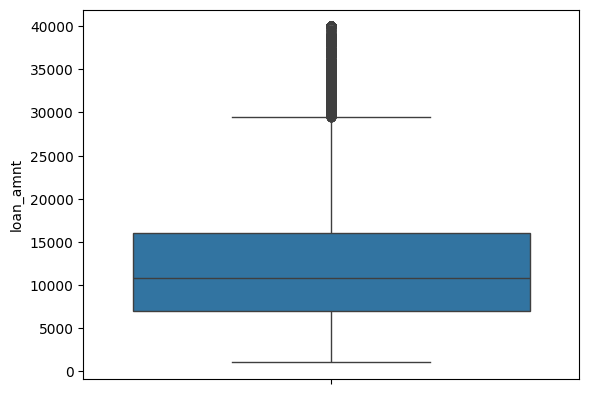

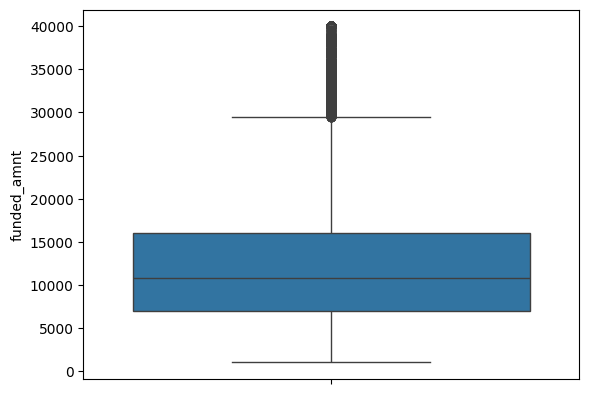

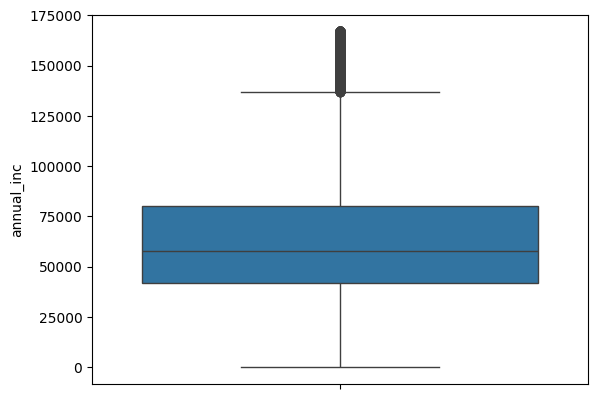

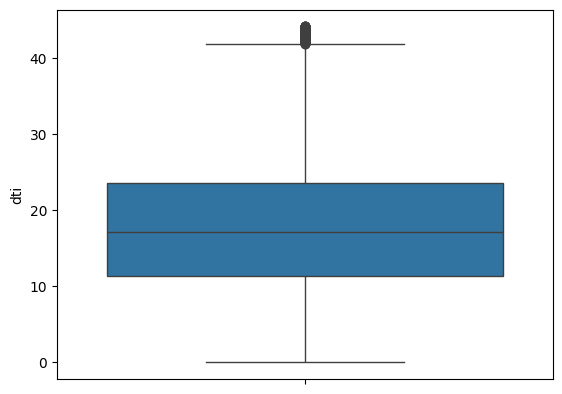

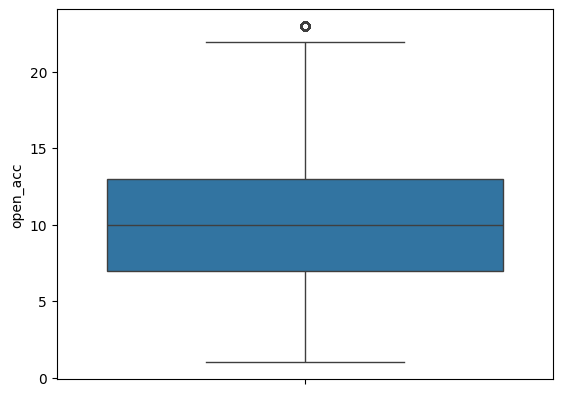

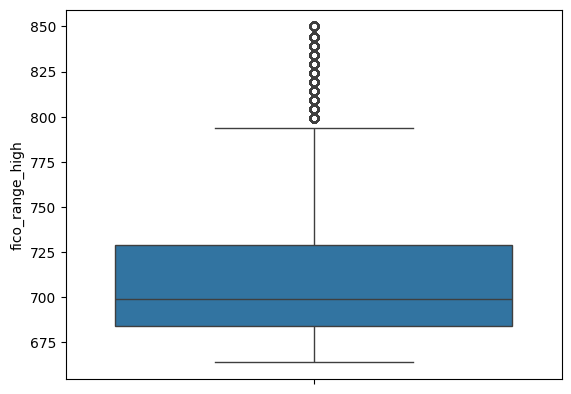

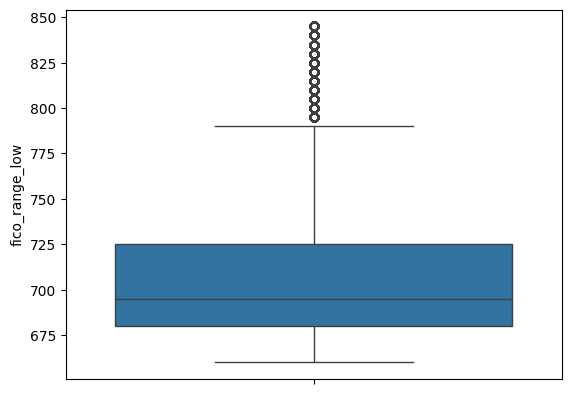

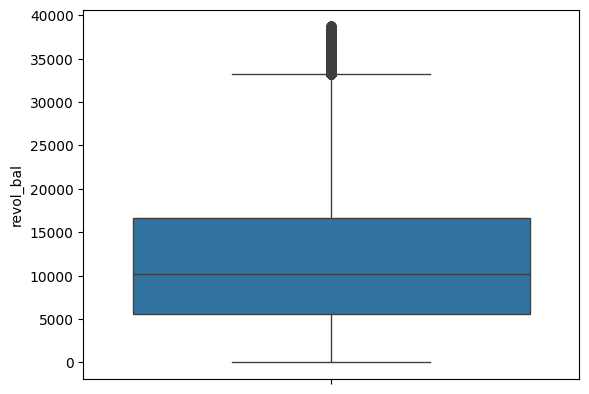

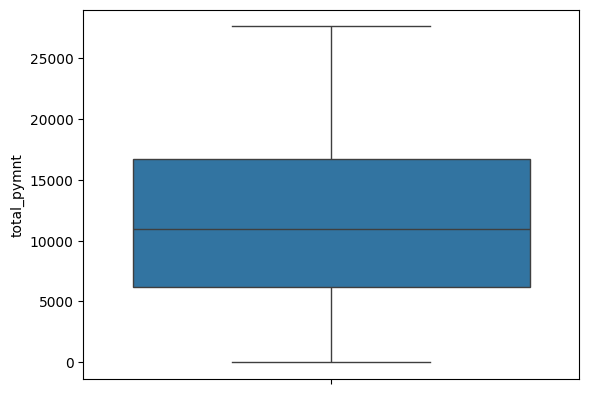

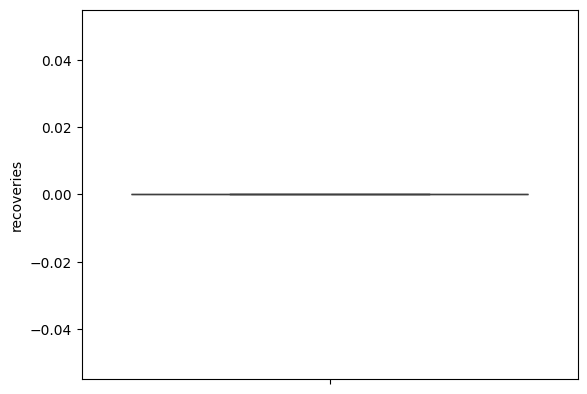

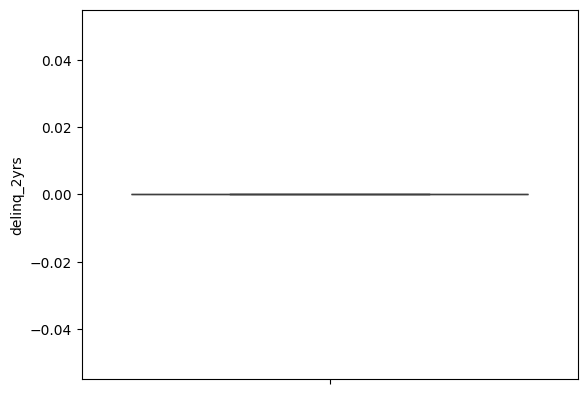

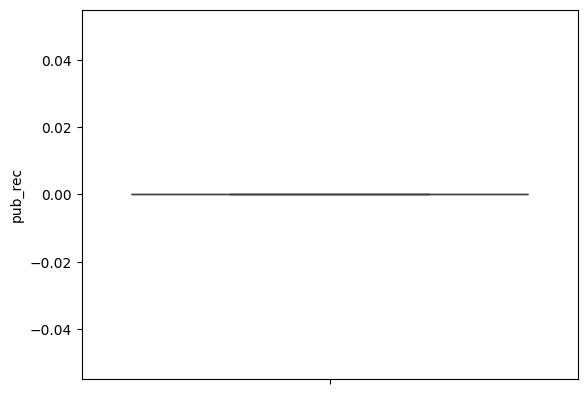

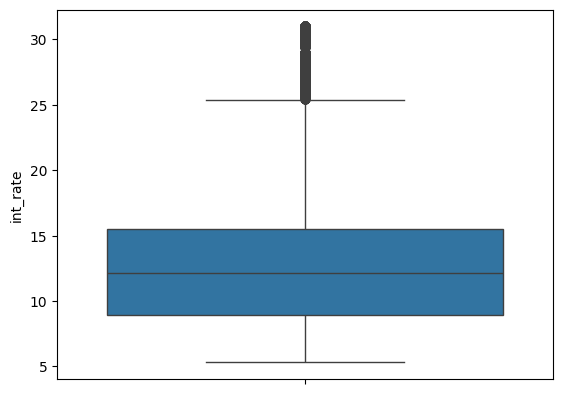

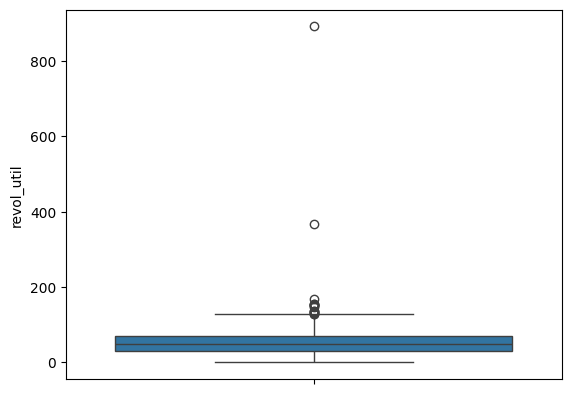

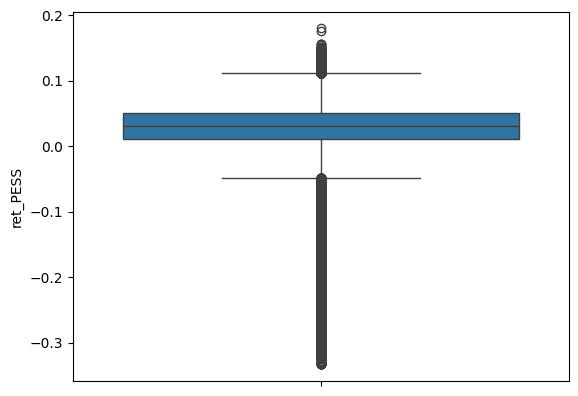

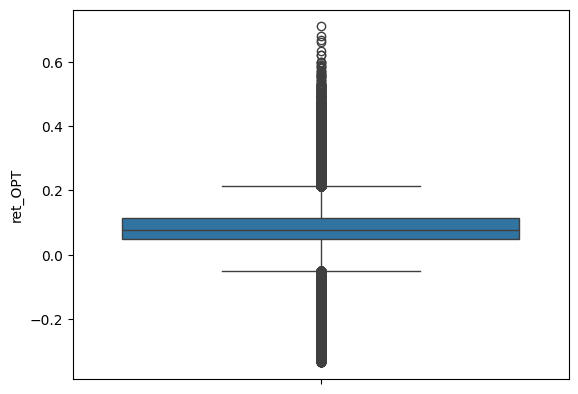

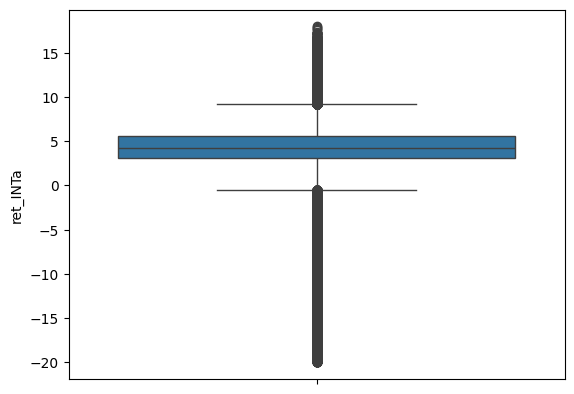

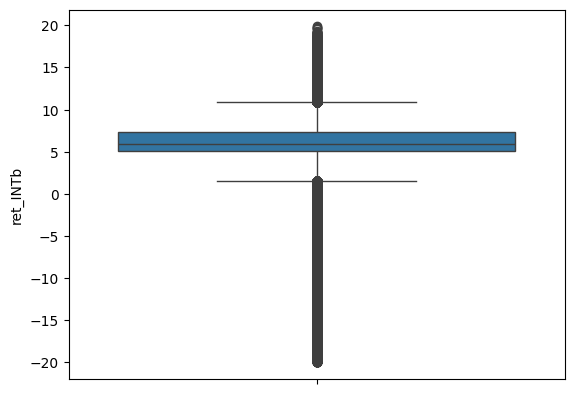

-----------Visualizing Categorical Features-------------
Field Name: term
Number of Distinct Values: 2
 36 months: 445918
 60 months: 106939


Field Name: grade
Number of Distinct Values: 7
B: 167517
C: 142262
A: 130054
D: 74209
E: 28469
F: 8261
G: 2085


Field Name: emp_length
Number of Distinct Values: 11
10+ years: 158516
2 years: 53887
< 1 year: 49475
3 years: 47898
1 year: 39792
5 years: 37381
4 years: 36127
6 years: 27383
7 years: 25107
8 years: 24060
9 years: 19435


Field Name: home_ownership
Number of Distinct Values: 6
RENT: 246659
MORTGAGE: 245642
OWN: 60091
ANY: 419
OTHER: 27
NONE: 19


Field Name: verification_status
Number of Distinct Values: 3
Not Verified: 217833
Source Verified: 196565
Verified: 138459


Field Name: loan_status
Number of Distinct Values: 7
Fully Paid: 467009
Charged Off: 51609
Late (31-120 days): 18362
In Grace Period: 10299
Late (16-30 days): 4646
Default: 523
Does not meet the credit policy. Status:Fully Paid: 409


Field Name: purpose
Number of Dist

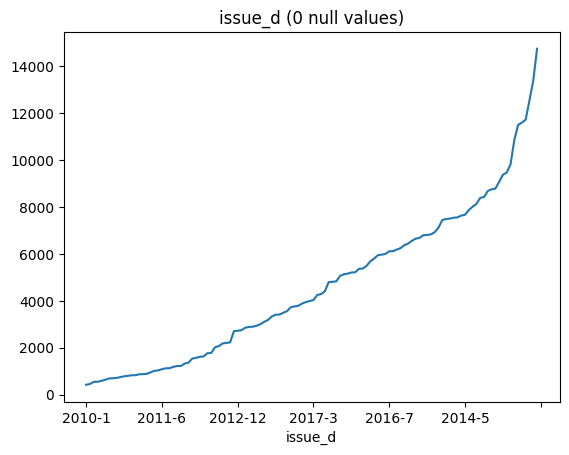

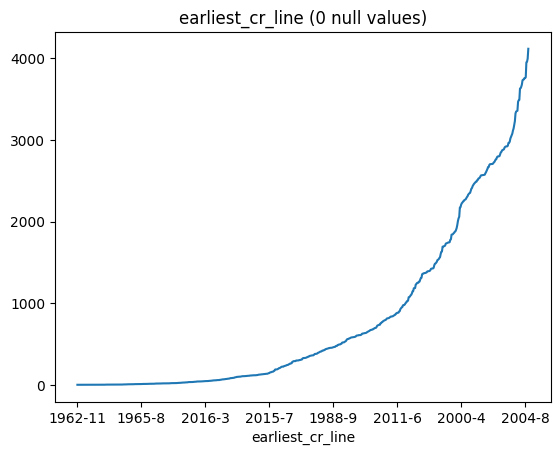

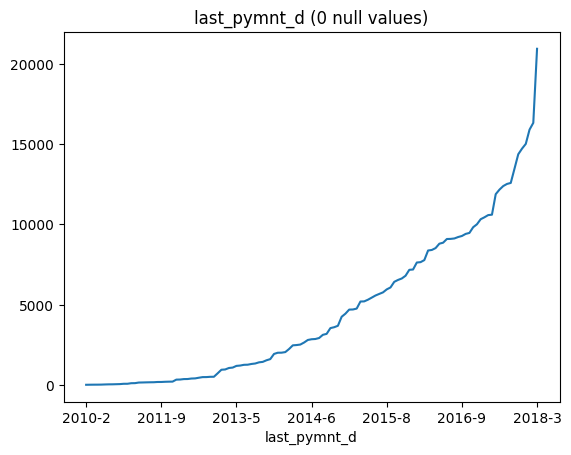

In [35]:
# visualize continuous features
print("-----------Visualizing Continuous Features-------------")
visualize_float_columns()

# visulaize categorical features

print("-----------Visualizing Categorical Features-------------")
visualize_cat_columns()

# visualize date columns
print("-----------Visualizing Date Features-------------")
visualize_date_columns()

### Handle outliers

In [29]:
# There are quite a few outliers.
# Please identify top-k (decide this based on the visualization) features where outliers are most obvious
n_rows = len(final_data)
print(n_rows)

final_data = final_data[(final_data['annual_inc'] >= final_data['annual_inc'].quantile(0.25) - 1.5 * (final_data['annual_inc'].quantile(0.75) - final_data['annual_inc'].quantile(0.25))) & (final_data['annual_inc'] <= final_data['annual_inc'].quantile(0.75) + 1.5 * (final_data['annual_inc'].quantile(0.75) - final_data['annual_inc'].quantile(0.25)))] # remove outliers based 1st obvious feature
final_data = final_data[(final_data['dti'] >= final_data['dti'].quantile(0.25) - 1.5 * (final_data['dti'].quantile(0.75) - final_data['dti'].quantile(0.25))) & (final_data['dti'] <= final_data['dti'].quantile(0.75) + 1.5 * (final_data['dti'].quantile(0.75) - final_data['dti'].quantile(0.25)))] # remove outliers based 2nd obvious feature
final_data = final_data[(final_data['open_acc'] >= final_data['open_acc'].quantile(0.25) - 1.5 * (final_data['open_acc'].quantile(0.75) - final_data['open_acc'].quantile(0.25))) & (final_data['open_acc'] <= final_data['open_acc'].quantile(0.75) + 1.5 * (final_data['open_acc'].quantile(0.75) - final_data['open_acc'].quantile(0.25)))] # remove outliers based 3rd obvious feature
final_data = final_data[(final_data['revol_bal'] >= final_data['revol_bal'].quantile(0.25) - 1.5 * (final_data['revol_bal'].quantile(0.75) - final_data['revol_bal'].quantile(0.25))) & (final_data['revol_bal'] <= final_data['revol_bal'].quantile(0.75) + 1.5 * (final_data['revol_bal'].quantile(0.75) - final_data['revol_bal'].quantile(0.25)))] # remove outliers based 4th obvious feature
final_data = final_data[(final_data['total_pymnt'] >= final_data['total_pymnt'].quantile(0.25) - 1.5 * (final_data['total_pymnt'].quantile(0.75) - final_data['total_pymnt'].quantile(0.25))) & (final_data['total_pymnt'] <= final_data['total_pymnt'].quantile(0.75) + 1.5 * (final_data['total_pymnt'].quantile(0.75) - final_data['total_pymnt'].quantile(0.25)))] # remove outliers based 5th obvious feature
final_data = final_data[(final_data['recoveries'] >= final_data['recoveries'].quantile(0.25) - 1.5 * (final_data['recoveries'].quantile(0.75) - final_data['recoveries'].quantile(0.25))) & (final_data['recoveries'] <= final_data['recoveries'].quantile(0.75) + 1.5 * (final_data['recoveries'].quantile(0.75) - final_data['recoveries'].quantile(0.25)))] # remove outliers based 6th obvious feature
final_data = final_data[(final_data['delinq_2yrs'] >= final_data['delinq_2yrs'].quantile(0.25) - 1.5 * (final_data['delinq_2yrs'].quantile(0.75) - final_data['delinq_2yrs'].quantile(0.25))) & (final_data['delinq_2yrs'] <= final_data['delinq_2yrs'].quantile(0.75) + 1.5 * (final_data['delinq_2yrs'].quantile(0.75) - final_data['delinq_2yrs'].quantile(0.25)))] # remove outliers based 7th obvious feature
final_data = final_data[(final_data['pub_rec'] >= final_data['pub_rec'].quantile(0.25) - 1.5 * (final_data['pub_rec'].quantile(0.75) - final_data['pub_rec'].quantile(0.25))) & (final_data['pub_rec'] <= final_data['pub_rec'].quantile(0.75) + 1.5 * (final_data['pub_rec'].quantile(0.75) - final_data['pub_rec'].quantile(0.25)))] # remove outliers based 8th obvious feature

print("Removed " + str(n_rows - len(final_data)) + " rows")

2765415
Removed 1306801 rows


In [30]:
# Remove all loans that are still current
n_rows = len(final_data)

final_data = final_data.loc[final_data["loan_status"] != "Current"]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 899258 rows


In [31]:
# Only include loans isssued since 2010
n_rows = len(final_data)

final_data = final_data.loc[final_data['issue_d'] >= pd.to_datetime("2010-01-01")]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 5002 rows


### Drop null values

In [32]:
# Deal with null values. We allow cateogrical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)

final_data = final_data.dropna(subset=required_cols, how='any') # drop rows that contain null based only on "required_cols"

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 1497 rows


### Visualize clean data

-----------Visualizing Continuous Features-------------


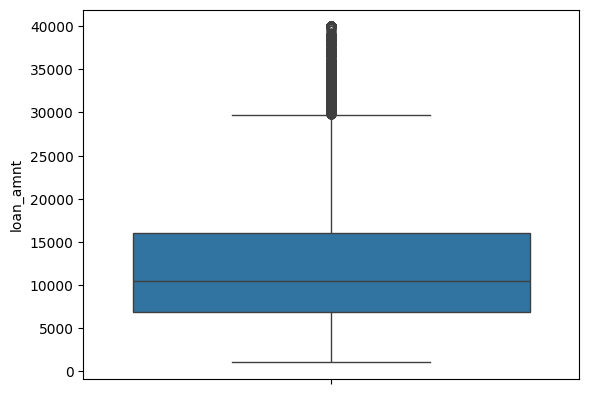

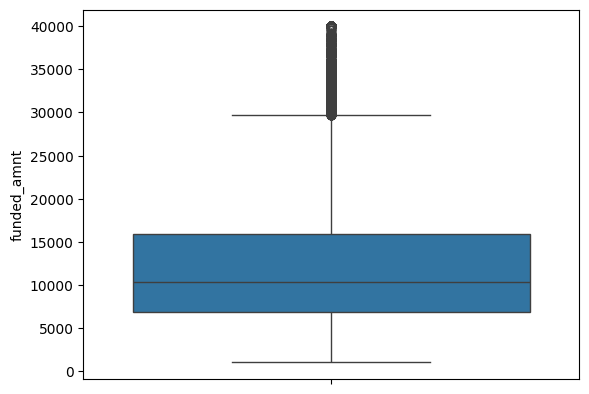

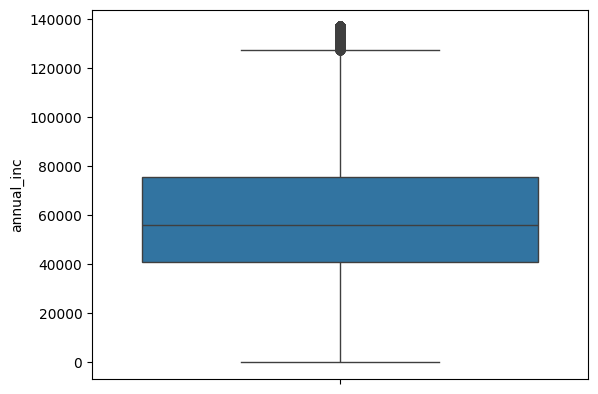

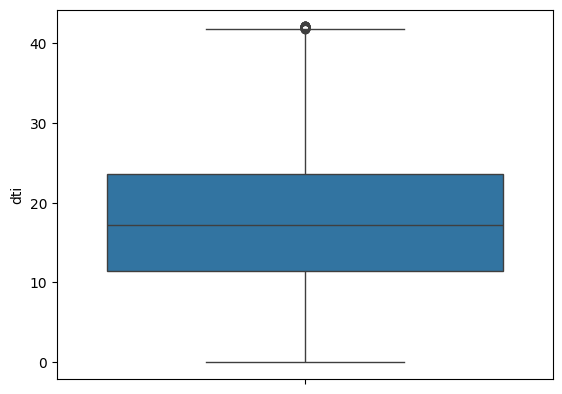

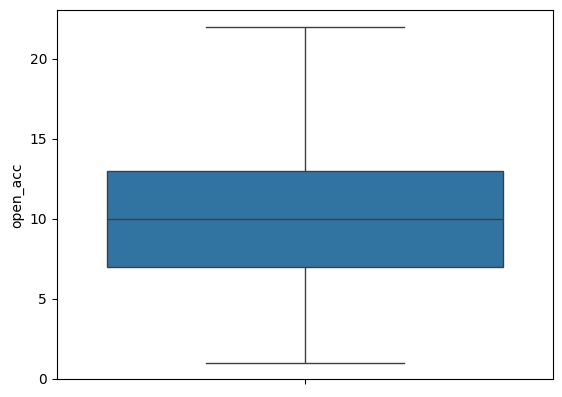

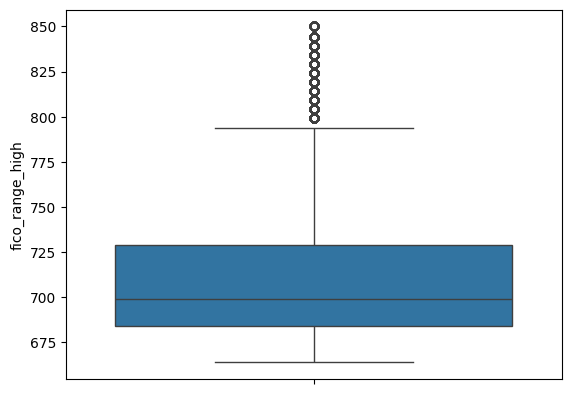

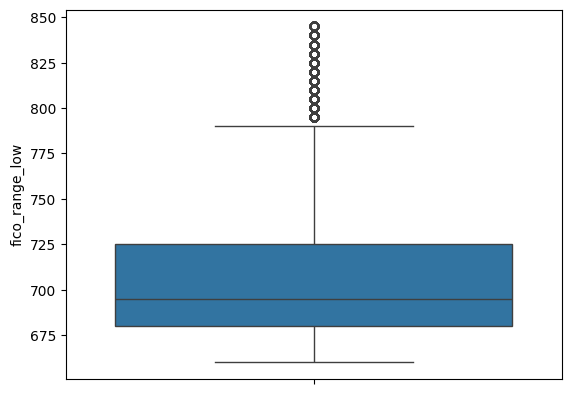

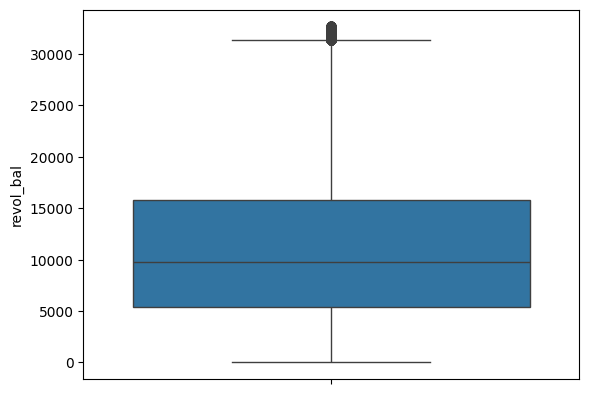

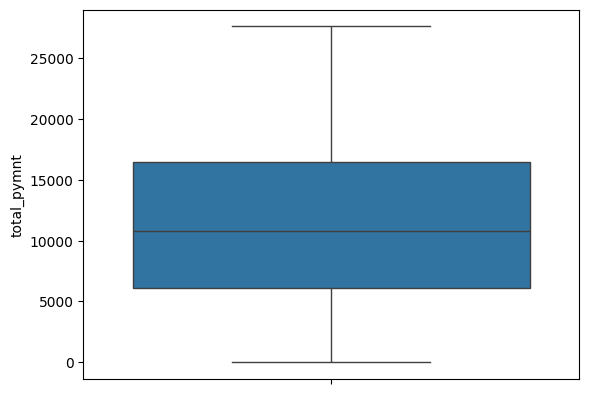

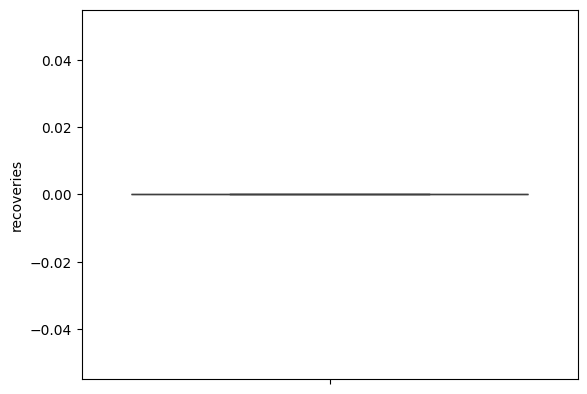

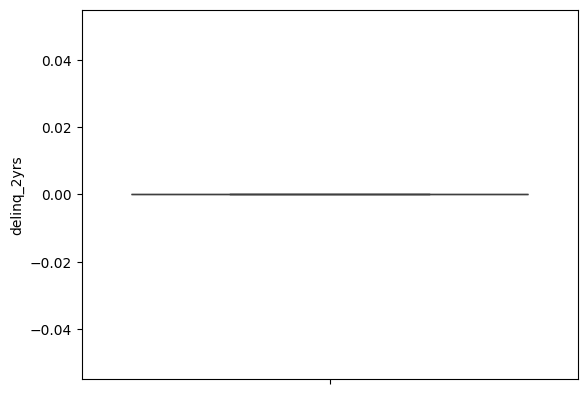

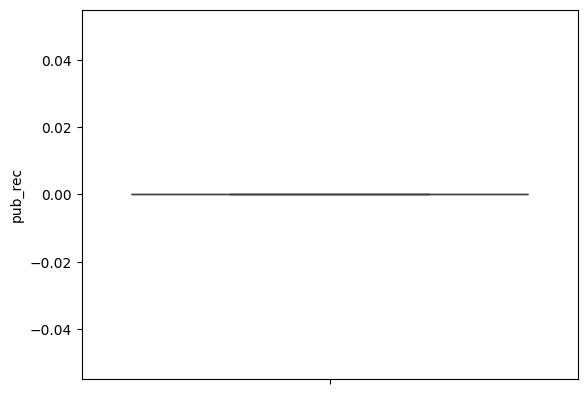

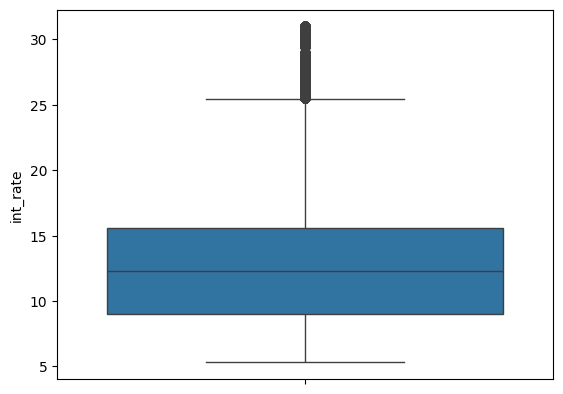

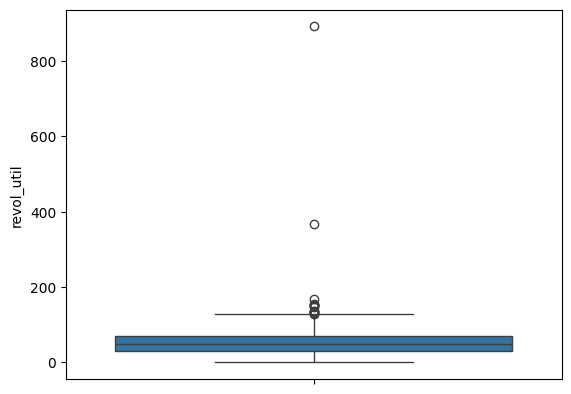

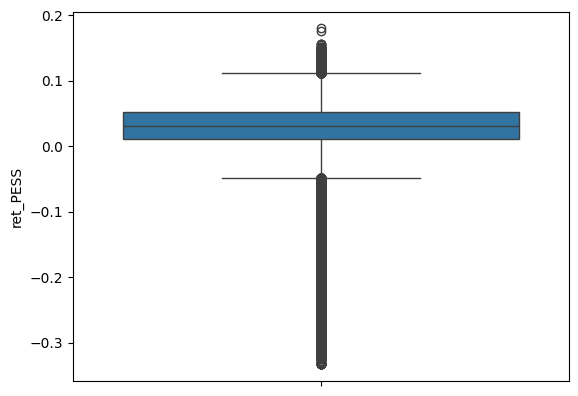

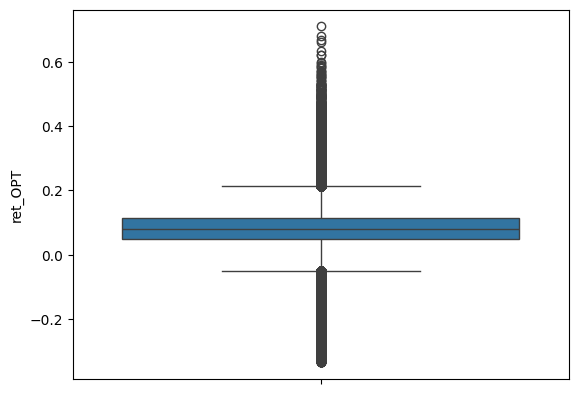

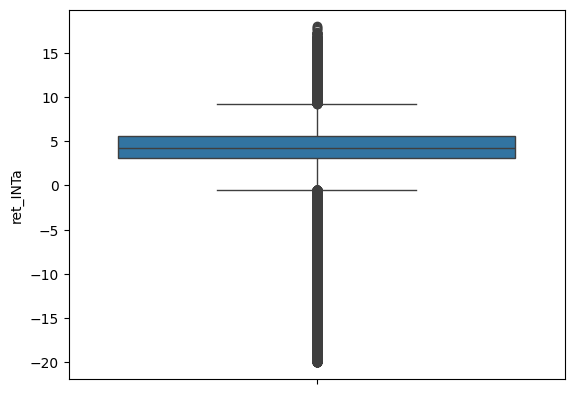

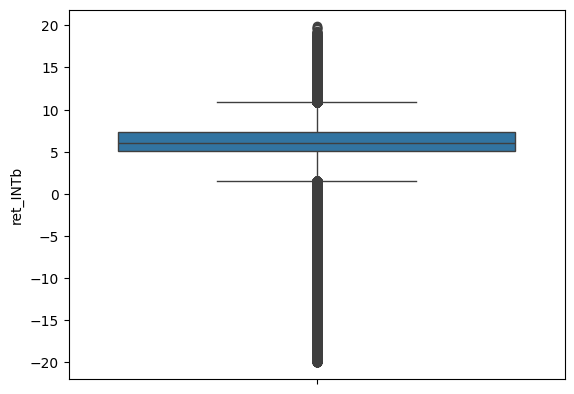

-----------Visualizing Categorical Features-------------
Field Name: term
Number of Distinct Values: 2
 36 months: 422832
 60 months: 99732


Field Name: grade
Number of Distinct Values: 7
B: 158618
C: 135383
A: 120857
D: 70782
E: 27115
F: 7840
G: 1969


Field Name: emp_length
Number of Distinct Values: 11
10+ years: 146917
2 years: 51446
< 1 year: 46990
3 years: 45682
1 year: 37970
5 years: 35587
4 years: 34356
6 years: 25996
7 years: 23808
8 years: 22781
9 years: 18299


Field Name: home_ownership
Number of Distinct Values: 6
RENT: 238313
MORTGAGE: 226683
OWN: 57125
ANY: 399
OTHER: 26
NONE: 18


Field Name: verification_status
Number of Distinct Values: 3
Not Verified: 206602
Source Verified: 185419
Verified: 130543


Field Name: loan_status
Number of Distinct Values: 7
Fully Paid: 442363
Charged Off: 48422
Late (31-120 days): 17116
In Grace Period: 9481
Late (16-30 days): 4310
Default: 486
Does not meet the credit policy. Status:Fully Paid: 386


Field Name: purpose
Number of Distin

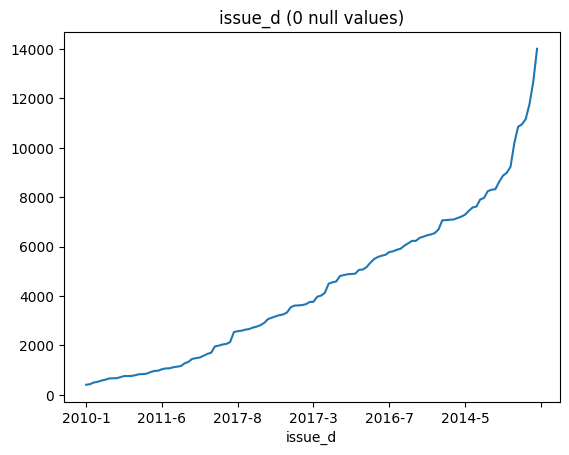

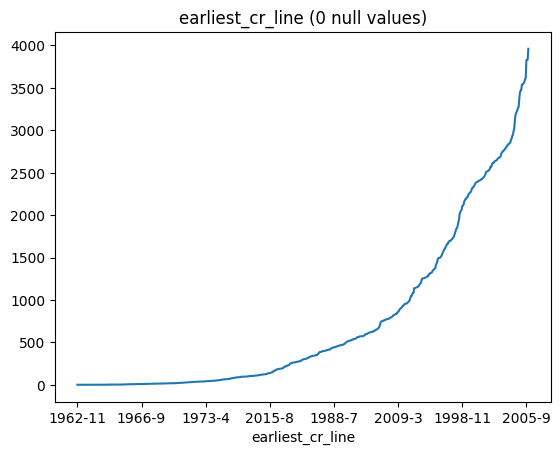

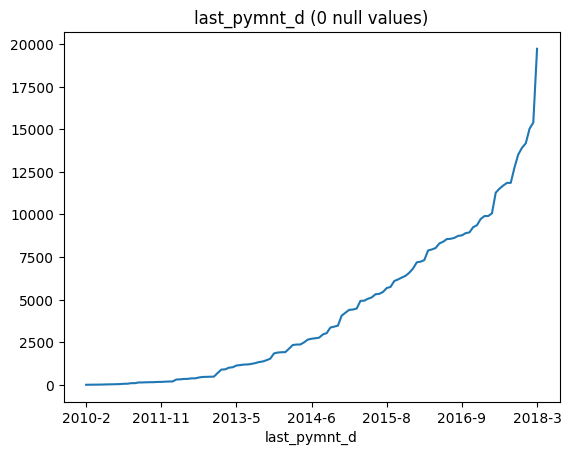

In [42]:
# Visualize the data again after cleaning

# visualize continuous features
print("-----------Visualizing Continuous Features-------------")
visualize_float_columns()

# visulaize categorical features

print("-----------Visualizing Categorical Features-------------")
visualize_cat_columns()

# visualize date columns
print("-----------Visualizing Date Features-------------")
visualize_date_columns()

<Axes: >

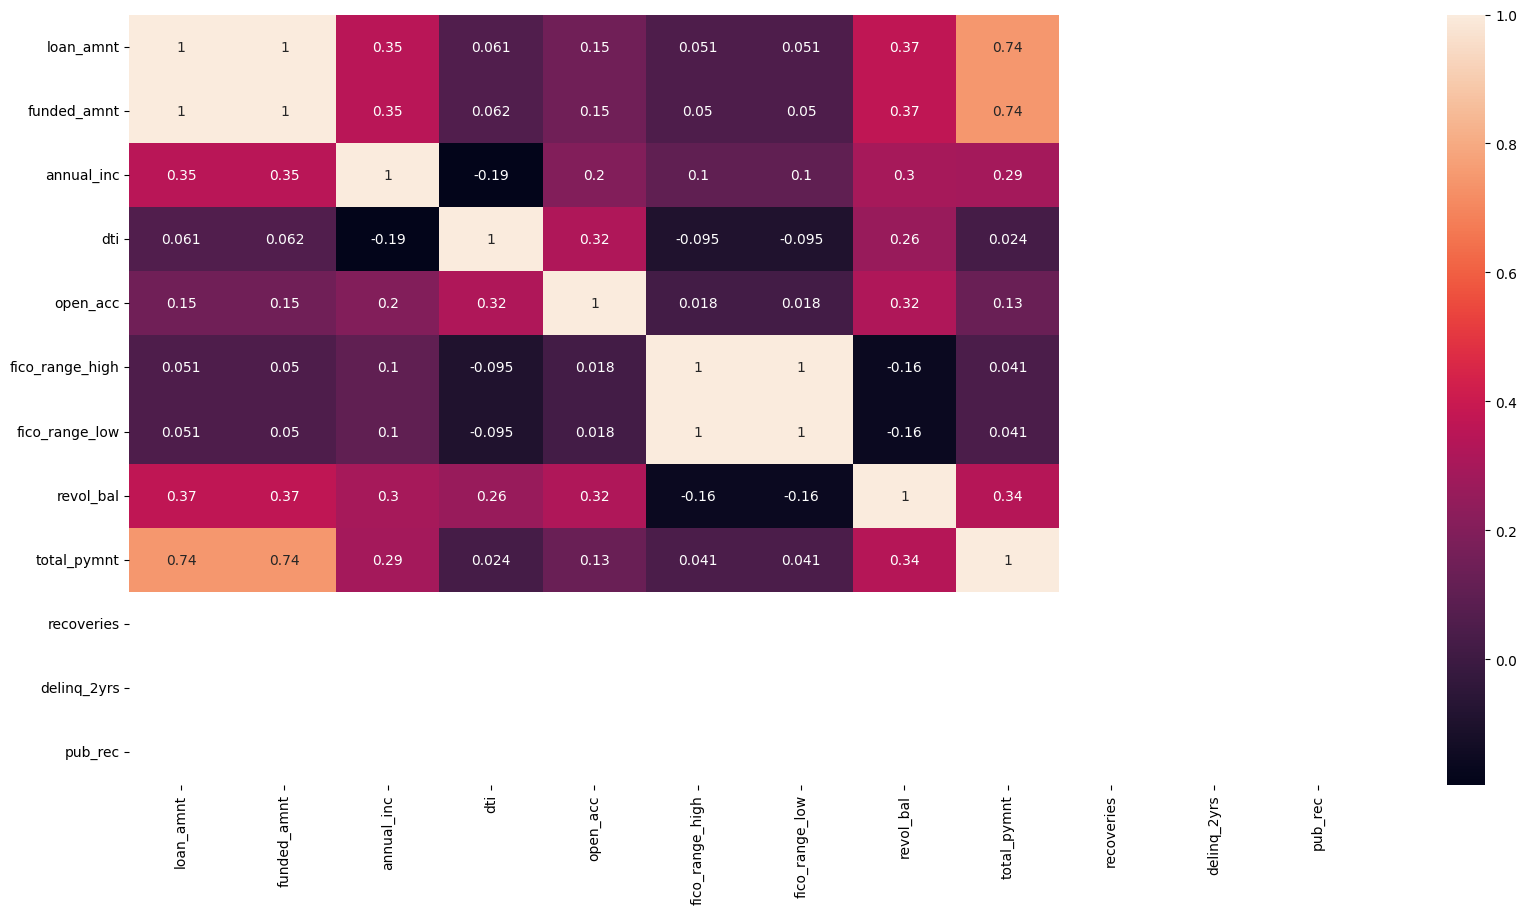

In [48]:
# Visualize the feature correlations
    # You can compute the correlation among features and display a heat-map of the matrix
    # OR use sns scatter or pairplot
# correlation matrix

#final_data['issue_d_year'] = final_data['issue_d'].apply(lambda x: x.year if x is not None else None)
#final_data['issue_d_month'] = final_data['issue_d'].apply(lambda x: x.month if x is not None else None)

#final_data['earliest_cr_line_year'] = final_data['earliest_cr_line'].apply(lambda x: x.year if x is not None else None)
#final_data['earliest_cr_line_month'] = final_data['earliest_cr_line'].apply(lambda x: x.month if x is not None else None)

#final_data['last_pymnt_d_year'] = final_data['last_pymnt_d'].apply(lambda x: x.year if x is not None else None)
#final_data['last_pymnt_d_month'] = final_data['last_pymnt_d'].apply(lambda x: x.month if x is not None else None)

#new_final_data = final_data.drop(columns=['issue_d', 'earliest_cr_line', 'last_pymnt_d'])
#new_final_data = pd.get_dummies(new_final_data, columns=cat_cols)
new_final_data = final_data[float_cols]

corr = new_final_data.corr()

fig, ax = plt.subplots(figsize=(20, 10))
# pass the axis to draw on
sns.heatmap(corr, ax=ax, annot=True
            # cmap="PiYG", center=0 # uncomment this line for a different color scheme
           )

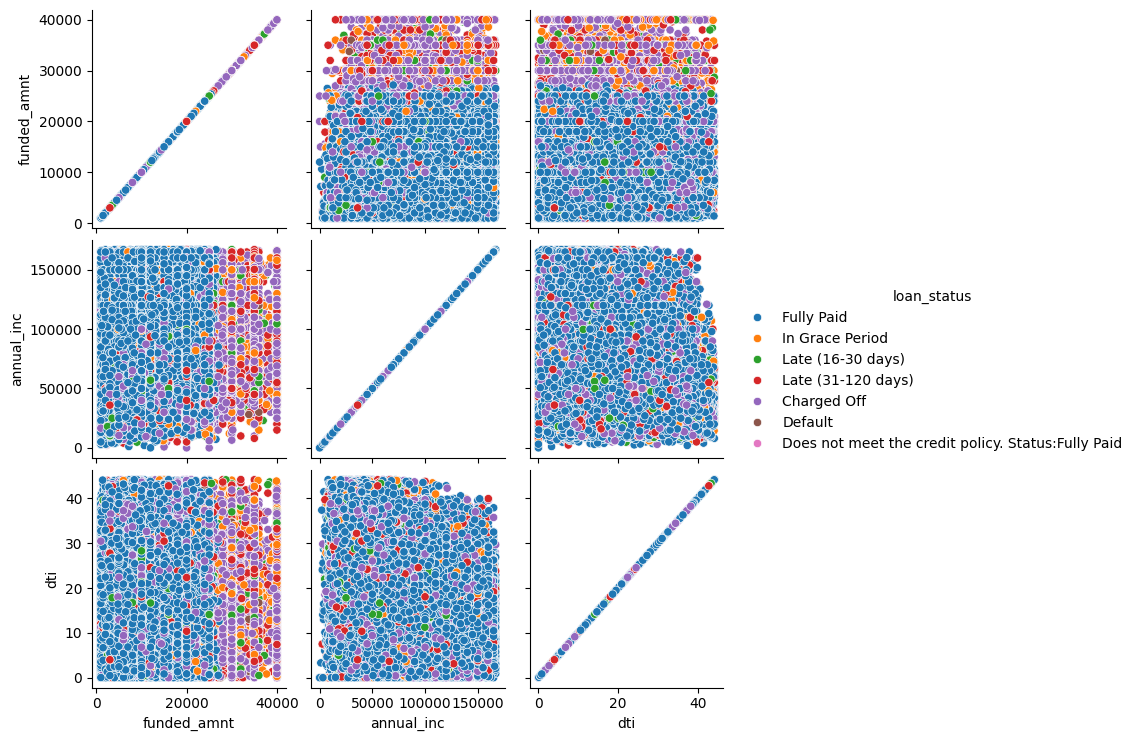

In [33]:
# pair plot

# Visualize relation between loan status and features
# sns pairplot or scatter plot. Refer to recitations

#g = sns.pairplot(data=final_data, hue='loan_status',
#                 vars=float_cols,
#                 diag_kind=None)# , plot_kws={'scatter_kws': {'alpha': 0.3}})
g = sns.pairplot(data=final_data, hue='loan_status',
                 vars=['funded_amnt', 'annual_inc', 'dti'],
                 diag_kind=None)# , plot_kws={'scatter_kws': {'alpha': 0.3}})
g.set(alpha=0.1)


What do you observe after removing the outliers?

On removing the outliers, we observe that the distributions are more compact and mostly cenetered around the median, indicating that the values are more within a typical range(less influence of the extreme values).

### Data Exploration
Solution to Q.7 from the handout

In [31]:
# Find the percentage of loans by grade, the default by grade,
# and the return of each grade
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()

default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret_by_grade_OPT = final_data.groupby('grade')['ret_OPT'].mean() # average return for M2-Optimistic for each loan grade
ret_by_grade_PESS = final_data.groupby('grade')['ret_PESS'].mean() # average return for M1-Pessimistic for each loan grade
ret_by_grade_INTa = final_data.groupby('grade')['ret_INTa'].mean() # average return for M3
ret_by_grade_INTb = final_data.groupby('grade')['ret_INTb'].mean() # average return for M3
int_rate_by_grade = final_data.groupby('grade')['int_rate'].mean() # average interest rate for each grade

combined = pd.DataFrame(perc_by_grade)
combined.columns = ['perc_of_loans']
combined['perc_default'] = default_by_grade
combined['avg_int_rate'] = int_rate_by_grade
combined['return_OPT'] = ret_by_grade_OPT
combined['return_PESS'] = ret_by_grade_PESS
combined['return_INTa'] = ret_by_grade_INTa
combined['return_INTb'] = ret_by_grade_INTb

combined

,perc_of_loans,perc_default,avg_int_rate,return_OPT,return_PESS,return_INTa,return_INTb
grade,,,,,,,
A,23.523985,6.010580,7.171949,0.040458,0.011854,2.789001,4.465077
B,30.300240,11.115290,10.913106,0.056742,0.015255,2.958533,4.631524
C,25.732151,18.797008,14.240790,0.064136,0.007184,2.397728,4.046303
D,13.422820,25.871525,18.190588,0.071358,0.000951,1.829927,3.439009
E,5.149433,32.930556,21.533365,0.079150,-0.004434,1.407965,2.987254
F,1.494238,37.997821,25.190539,0.088958,-0.006718,0.972698,2.520351
G,0.377132,45.899281,28.112859,0.074603,-0.034063,-1.200156,0.232018


Based on the output of previous cell, write down your answers to Q.7 from the handout.

### Save a Pickle

In [35]:
# Remove the "total_pymnt" and "recoveries" from the list of continuous features
continuous_features = [col for col in float_cols if col not in ('total_pymnt', 'recoveries')]
continuous_features

['loan_amnt',
 'funded_amnt',
 'annual_inc',
 'dti',
 'open_acc',
 'fico_range_high',
 'fico_range_low',
 'revol_bal',
 'delinq_2yrs',
 'pub_rec']

Why did we remove `total_pymt` and `recoveries` from the data for the task of predicting whether to give loan or not, although these are highly predictive features?

Removing total_pymt and recoveries from datasets used to predict loan approval is essential due to their nature as post-outcome features:

Temporal Leakage: These features contain information available only after the loan's outcome is determined, leading to unrealistic model performance by introducing future data into the prediction process.

Causality vs. Correlation: They are outcomes of the loan process, not causal factors that can be used to assess the risk of a new loan.

Model Generalizability: For a model to be useful, it must rely on data available at the time of loan application. These features don’t meet this criterion.

In [36]:
# save the prepared data for modeling in next Phase.
pickle.dump( [final_data, discrete_features, continuous_features, ret_cols], open(pickle_file, "wb") )